In [6]:
import numpy as np
from optimal_levee_bandit import load_cost_curves, prune_candidates
from beta_dueling_bandit_analytical import run_beta_dueling_bandit_analytical

# 1. Load cost curves for your city
damage_file     = "Damage_cost_curves.tab"
protection_file = "Protection_cost_curves_high_estimate.tab"
city = "Halmstad"
heights, damage_costs, protection_costs = load_cost_curves(damage_file, protection_file, city)

# 2. Define analysis horizon and prune deterministic candidates
years_range = (2025, 2100)
n_years = years_range[1] - years_range[0] + 1
candidate_indices = prune_candidates(
    heights=heights,
    protection_costs=protection_costs,
    damage_costs=damage_costs,
    n_years=n_years
)
print("Candidate heights (m):", heights[candidate_indices])


Candidate heights (m): [ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12. ]


In [ ]:

# 3. Load posterior draws and mean sea level paths
pp = np.load("pp_inputs_halmsdad_pp_mixture_2025_2100.npz")
posterior_params = {
    "eta0": pp["eta0"],
    "eta1": pp["eta1"],
    "alpha0": pp["alpha0"],
    "xi": pp["xi"],
    "u": float(pp["u"]),  # threshold in cm
}
years_future   = pp["years_future"]
X_future_paths = pp["X_future_paths"]  # shape (M_pred, T_future) in cm

# 4. Run the analytical Beta-dueling bandit
#    - delta: misidentification probability target (e.g., 0.05 for 95% confidence)
#    - max_rounds: maximum number of simulated scenarios
#    - check_every: evaluate stopping rule every this many scenarios
rng = np.random.default_rng(42)
best_height, history = run_beta_dueling_bandit_analytical(
    heights=heights,
    damage_costs=damage_costs,
    protection_costs=protection_costs,
    candidate_indices=candidate_indices,
    years_all=years_future,
    X_pred_paths_cm=X_future_paths,
    posterior_params=posterior_params,
    years_range=years_range,
    delta=0.05,
    max_rounds=50_000,
    check_every=1_000,
    rng=rng,
    verbose=True,
)

print(f"Selected design height: {best_height:.2f} m")
print("Diagnostic history:", history)


In [2]:

import numpy as np
from beta_dueling_bandit_analytical import (
    run_beta_dueling_bandit_analytical,
    simulate_annual_max_pp,
    _interpolate_damage,
)

# --- 1. Load cost curves for your city (same as before) ---
damage_file     = "Damage_cost_curves.tab"
protection_file = "Protection_cost_curves_high_estimate.tab"
city = "Halmstad"
heights, damage_costs, protection_costs = load_cost_curves(damage_file, protection_file, city)

# If you don’t have a pruning function handy, just use all heights:
candidate_indices = np.arange(heights.size, dtype=int)

# --- 2. Load posterior draws and mean sea level paths (same as your dueling notebook) ---
pp = np.load("pp_inputs_halmsdad_pp_mixture_2025_2100.npz")
posterior_params = {
    "eta0":   pp["eta0"],
    "eta1":   pp["eta1"],
    "alpha0": pp["alpha0"],
    "xi":     pp["xi"],
    "u":      float(pp["u"]),  # threshold in cm
}
years_future   = pp["years_future"]          # 1D array of years
X_future_paths = pp["X_future_paths"]        # shape (M_pred, T_future) in cm

# Analysis horizon
years_range = (2025, 2100)


# --- 4. Estimate the mean total cost for the chosen height via Monte Carlo ---

def estimate_mean_total_cost_for_height(
    target_height: float,
    heights: np.ndarray,
    damage_costs: np.ndarray,
    protection_costs: np.ndarray,
    years_all: np.ndarray,
    X_pred_paths_cm: np.ndarray,
    posterior_params: dict,
    years_range=(2025, 2100),
    n_replications: int = 5000,
    rng: np.random.Generator | None = None,
):
    """
    Monte Carlo estimator of E[total_cost | height = target_height],
    using the same Poisson–GPD + MSL model as the dueling bandit.
    """
    if rng is None:
        rng = np.random.default_rng()

    # Find index of the target height in the full grid
    # (assumes exact match; otherwise you can use np.argmin(|h - target_height|))
    i_h = int(np.where(heights == target_height)[0][0])

    # Basic setup
    start_year, end_year = years_range
    n_years = end_year - start_year + 1

    years_all = np.asarray(years_all, dtype=int)
    mask = (years_all >= start_year) & (years_all <= end_year)
    year_idx = np.where(mask)[0]
    if year_idx.size != n_years:
        raise ValueError(
            f"years_all and years_range mismatch: expected {n_years} years, found {year_idx.size}"
        )

    X_paths_slice_cm = np.asarray(X_pred_paths_cm, dtype=float)[:, year_idx]
    M_pred = X_paths_slice_cm.shape[0]

    # Flatten posterior parameter draws
    eta0_s   = np.asarray(posterior_params["eta0"]).reshape(-1)
    eta1_s   = np.asarray(posterior_params["eta1"]).reshape(-1)
    alpha0_s = np.asarray(posterior_params["alpha0"]).reshape(-1)
    xi_s     = np.asarray(posterior_params["xi"]).reshape(-1)
    n_total  = eta0_s.size

    u_cm = float(posterior_params.get("u", 60.0))

    # Precompute some constants
    h_m          = float(target_height)
    prot_cost    = float(protection_costs[i_h])
    height_grid_m = heights
    damage_grid   = damage_costs

    total_cost_samples = np.empty(n_replications, dtype=float)

    for r in range(n_replications):
        # 1. Draw parameter index and MSL path index
        i_draw = rng.integers(low=0, high=n_total)
        m_path = rng.integers(low=0, high=M_pred)

        eta0   = float(eta0_s[i_draw])
        eta1   = float(eta1_s[i_draw])
        alpha0 = float(alpha0_s[i_draw])
        xi     = float(xi_s[i_draw])

        X_t_series_cm = X_paths_slice_cm[m_path]  # (n_years,)

        # 2. Simulate annual maxima (cm) and convert to metres
        maxima_cm = simulate_annual_max_pp(
            eta0=eta0,
            eta1=eta1,
            alpha0=alpha0,
            xi=xi,
            X_t_series_cm=X_t_series_cm,
            u_cm=u_cm,
            rng=rng,
        )
        maxima_m = maxima_cm * 0.01  # cm -> m

        # 3. Compute total cost at this height
        exceedances = np.where(maxima_m > h_m, maxima_m, 0.0)
        yearly_damage = _interpolate_damage(exceedances, height_grid_m, damage_grid)
        total_damage  = float(np.sum(yearly_damage))

        total_cost_samples[r] = prot_cost + total_damage

    # Monte Carlo mean and standard error
    mean_cost = float(np.mean(total_cost_samples))
    se_cost   = float(np.std(total_cost_samples, ddof=1) / np.sqrt(n_replications))
    return mean_cost, se_cost, total_cost_samples


mean_best, se_best, samples_best = estimate_mean_total_cost_for_height(
    target_height=best_height,
    heights=heights,
    damage_costs=damage_costs,
    protection_costs=protection_costs,
    years_all=years_future,
    X_pred_paths_cm=X_future_paths,
    posterior_params=posterior_params,
    years_range=years_range,
    n_replications=100000,
    rng=np.random.default_rng(2024),
)

print(f"[Estimation] Mean total cost for best height {best_height:.2f} m ≈ {mean_best:.3f}")
print(f"[Estimation] Standard error ≈ {se_best:.3f}")


[Estimation] Mean total cost for best height 2.50 m ≈ 706.886
[Estimation] Standard error ≈ 4.694


[Estimation] Mean total cost for best height 2.50 m ≈ 706.886
[Estimation] Standard error ≈ 4.694

[Extremes] 99th percentile of total cost ≈ 5296.439
[Extremes] Max simulated total cost ≈ 140327.642
[Extremes] Number of 'extreme' simulations (>= 99th percentile): 1000 out of 100000


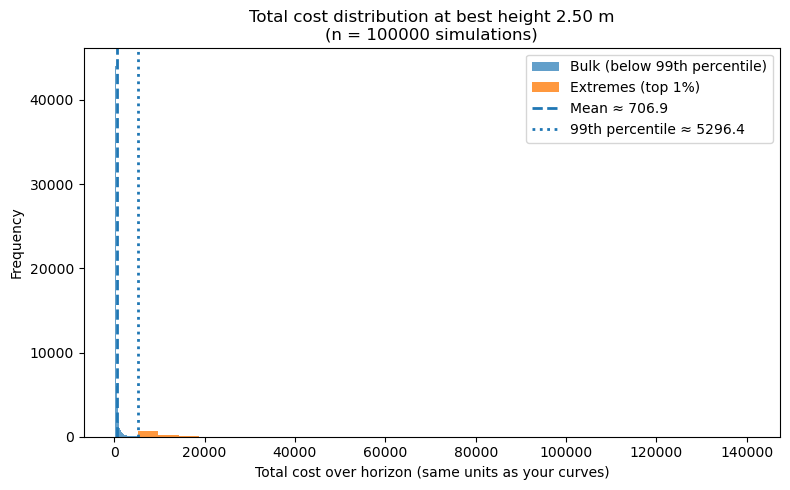

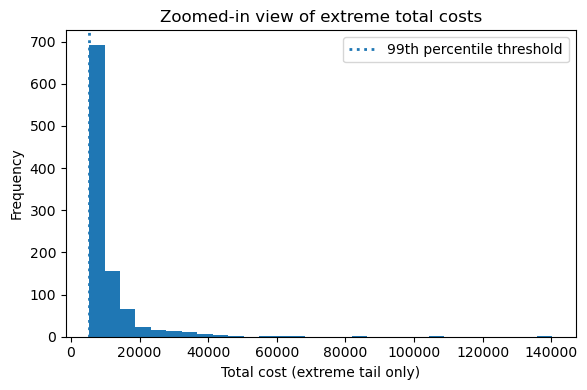

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from beta_dueling_bandit_analytical import (
    run_beta_dueling_bandit_analytical,
    simulate_annual_max_pp,
    _interpolate_damage,
)

# --- 1. Load cost curves for your city (same as before) ---
damage_file     = "Damage_cost_curves.tab"
protection_file = "Protection_cost_curves_high_estimate.tab"
city = "Halmstad"
heights, damage_costs, protection_costs = load_cost_curves(damage_file, protection_file, city)

# If you don’t have a pruning function handy, just use all heights:
candidate_indices = np.arange(heights.size, dtype=int)

# --- 2. Load posterior draws and mean sea level paths (same as your dueling notebook) ---
pp = np.load("pp_inputs_halmsdad_pp_mixture_2025_2100.npz")
posterior_params = {
    "eta0":   pp["eta0"],
    "eta1":   pp["eta1"],
    "alpha0": pp["alpha0"],
    "xi":     pp["xi"],
    "u":      float(pp["u"]),  # threshold in cm
}
years_future   = pp["years_future"]          # 1D array of years
X_future_paths = pp["X_future_paths"]        # shape (M_pred, T_future) in cm

# Analysis horizon
years_range = (2025, 2100)


# --- 3. (Optional) Run the analytical Beta-dueling bandit to pick best_height ---

rng = np.random.default_rng(42)

best_height = 2.5


# --- 4. Estimate the mean total cost for the chosen height via Monte Carlo ---

def estimate_mean_total_cost_for_height(
    target_height: float,
    heights: np.ndarray,
    damage_costs: np.ndarray,
    protection_costs: np.ndarray,
    years_all: np.ndarray,
    X_pred_paths_cm: np.ndarray,
    posterior_params: dict,
    years_range=(2025, 2100),
    n_replications: int = 5000,
    rng: np.random.Generator | None = None,
):
    """
    Monte Carlo estimator of E[total_cost | height = target_height],
    using the same Poisson–GPD + MSL model as the dueling bandit.
    """
    if rng is None:
        rng = np.random.default_rng()

    # Find index of the target height in the full grid
    # (assumes exact match; otherwise you can use np.argmin(|h - target_height|))
    i_h = int(np.where(heights == target_height)[0][0])

    # Basic setup
    start_year, end_year = years_range
    n_years = end_year - start_year + 1

    years_all = np.asarray(years_all, dtype=int)
    mask = (years_all >= start_year) & (years_all <= end_year)
    year_idx = np.where(mask)[0]
    if year_idx.size != n_years:
        raise ValueError(
            f"years_all and years_range mismatch: expected {n_years} years, found {year_idx.size}"
        )

    X_paths_slice_cm = np.asarray(X_pred_paths_cm, dtype=float)[:, year_idx]
    M_pred = X_paths_slice_cm.shape[0]

    # Flatten posterior parameter draws
    eta0_s   = np.asarray(posterior_params["eta0"]).reshape(-1)
    eta1_s   = np.asarray(posterior_params["eta1"]).reshape(-1)
    alpha0_s = np.asarray(posterior_params["alpha0"]).reshape(-1)
    xi_s     = np.asarray(posterior_params["xi"]).reshape(-1)
    n_total  = eta0_s.size

    u_cm = float(posterior_params.get("u", 60.0))

    # Precompute some constants
    h_m           = float(target_height)
    prot_cost     = float(protection_costs[i_h])
    height_grid_m = heights
    damage_grid   = damage_costs

    total_cost_samples = np.empty(n_replications, dtype=float)

    for r in range(n_replications):
        # 1. Draw parameter index and MSL path index
        i_draw = rng.integers(low=0, high=n_total)
        m_path = rng.integers(low=0, high=M_pred)

        eta0   = float(eta0_s[i_draw])
        eta1   = float(eta1_s[i_draw])
        alpha0 = float(alpha0_s[i_draw])
        xi     = float(xi_s[i_draw])

        X_t_series_cm = X_paths_slice_cm[m_path]  # (n_years,)

        # 2. Simulate annual maxima (cm) and convert to metres
        maxima_cm = simulate_annual_max_pp(
            eta0=eta0,
            eta1=eta1,
            alpha0=alpha0,
            xi=xi,
            X_t_series_cm=X_t_series_cm,
            u_cm=u_cm,
            rng=rng,
        )
        maxima_m = maxima_cm * 0.01  # cm -> m

        # 3. Compute total cost at this height
        exceedances = np.where(maxima_m > h_m, maxima_m, 0.0)
        yearly_damage = _interpolate_damage(exceedances, height_grid_m, damage_grid)
        total_damage  = float(np.sum(yearly_damage))

        total_cost_samples[r] = prot_cost + total_damage

    # Monte Carlo mean and standard error
    mean_cost = float(np.mean(total_cost_samples))
    se_cost   = float(np.std(total_cost_samples, ddof=1) / np.sqrt(n_replications))
    return mean_cost, se_cost, total_cost_samples


# --- 5. Run estimator and then plot histogram highlighting extremes ---

mean_best, se_best, samples_best = estimate_mean_total_cost_for_height(
    target_height=best_height,
    heights=heights,
    damage_costs=damage_costs,
    protection_costs=protection_costs,
    years_all=years_future,
    X_pred_paths_cm=X_future_paths,
    posterior_params=posterior_params,
    years_range=years_range,
    n_replications=100_000,
    rng=np.random.default_rng(2024),
)

print(f"[Estimation] Mean total cost for best height {best_height:.2f} m ≈ {mean_best:.3f}")
print(f"[Estimation] Standard error ≈ {se_best:.3f}")

# --- 6. Visualise the full distribution + highlight extreme values ---

# Choose a threshold for "extreme" – here top 1% of simulated total costs
p_extreme = 0.99
threshold_extreme = np.quantile(samples_best, p_extreme)

print(f"\n[Extremes] 99th percentile of total cost ≈ {threshold_extreme:.3f}")
print(f"[Extremes] Max simulated total cost ≈ {samples_best.max():.3f}")
print(f"[Extremes] Number of 'extreme' simulations (>= 99th percentile): "
      f"{(samples_best >= threshold_extreme).sum()} out of {samples_best.size}")

# Split into "bulk" and "extremes"
bulk_mask = samples_best < threshold_extreme
extreme_mask = ~bulk_mask

bulk_samples = samples_best[bulk_mask]
extreme_samples = samples_best[extreme_mask]

fig, ax = plt.subplots(figsize=(8, 5))

# Plot bulk of the distribution
ax.hist(
    bulk_samples,
    bins=60,
    alpha=0.7,
    label="Bulk (below 99th percentile)",
)

# Overlay extremes as separate histogram
if extreme_samples.size > 0:
    ax.hist(
        extreme_samples,
        bins=30,
        alpha=0.8,
        label="Extremes (top 1%)",
    )

# Vertical lines for mean and threshold
ax.axvline(mean_best, linestyle="--", linewidth=2, label=f"Mean ≈ {mean_best:.1f}")
ax.axvline(threshold_extreme, linestyle=":", linewidth=2,
           label=f"99th percentile ≈ {threshold_extreme:.1f}")

ax.set_xlabel("Total cost over horizon (same units as your curves)")
ax.set_ylabel("Frequency")
ax.set_title(f"Total cost distribution at best height {best_height:.2f} m\n"
             f"(n = {samples_best.size} simulations)")
ax.legend()
plt.tight_layout()
plt.show()

# Optional: zoomed-in histogram focusing only on extremes
if extreme_samples.size > 0:
    fig, ax = plt.subplots(figsize=(6, 4))
    ax.hist(extreme_samples, bins=30)
    ax.axvline(threshold_extreme, linestyle=":", linewidth=2,
               label="99th percentile threshold")
    ax.set_xlabel("Total cost (extreme tail only)")
    ax.set_ylabel("Frequency")
    ax.set_title("Zoomed-in view of extreme total costs")
    ax.legend()
    plt.tight_layout()
    plt.show()
